# Airbnb New User Bookings

**Dataset source** https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

## Data Description
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

**File descriptions**
- train_users.csv - the training set of users
- test_users.csv - the test set of users
    - id: user id
    - date_account_created: the date of account creation
    - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    - date_first_booking: date of first booking
    - gender
    - age
    - signup_method
    - signup_flow: the page a user came to signup up from
    - language: international language preference
    - affiliate_channel: what kind of paid marketing
    - affiliate_provider: where the marketing is e.g. google, craigslist, other
    - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    - signup_app
    - first_device_type
    - first_browser
    - country_destination: this is the target variable you are to predict
- sessions.csv - web sessions log for users
    - user_id: to be joined with the column 'id' in users table
    - action
    - action_type
    - action_detail
    - device_type
    - secs_elapsed
- countries.csv - summary statistics of destination countries in this dataset and their locations
- age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
- sample_submission.csv - correct format for submitting your predictions

# Import required packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as pySFun
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode

# Create SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName('Airbnb New User Bookings') \
    .getOrCreate()

# Data Wrangling

## Read Data

### Read Countries

In [4]:
CountriesData_schema = StructType([
    StructField("country_destination", StringType()),
    StructField("lat_destination", DoubleType()),
    StructField("lng_destination", DoubleType()),
    StructField("distance_km", DoubleType()),
    StructField("destination_km2", DoubleType()),
    StructField("destination_language", StringType()),
    StructField("language_levenshtein_distance", DoubleType()),
])

CountriesData = spark.read\
                    .format('csv')\
                    .option('header', 'true')\
                    .option('ignoreLeadingWhiteSpace', 'true')\
                    .schema(CountriesData_schema)\
                    .load('./data/countries.csv')

In [5]:
CountriesData.toPandas()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [25]:
print('We have ',CountriesData.count(), ' countries in the below schema')
CountriesData.printSchema()
CountriesData.toPandas().head()

We have  10  countries in the below schema
root
 |-- country_destination: string (nullable = true)
 |-- lat_destination: double (nullable = true)
 |-- lng_destination: double (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- destination_km2: double (nullable = true)
 |-- destination_language: string (nullable = true)
 |-- language_levenshtein_distance: double (nullable = true)



,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


### Read Age and Gender Buckets

In [27]:
AgeAndGenderBucketsData_schema = StructType([
    StructField("age_bucket", StringType()),
    StructField("country_destination", StringType()),
    StructField("gender", StringType()),
    StructField("population_in_thousands", DoubleType()),
    StructField("year", StringType()),
])

AgeAndGenderBucketsData = spark.read\
                            .format('csv')\
                            .option('header', 'true')\
                            .option('ignoreLeadingWhiteSpace', 'true')\
                            .schema(AgeAndGenderBucketsData_schema)\
                            .load('./data/age_gender_bkts.csv')

In [28]:
print('We have ', AgeAndGenderBucketsData.count(), ' Age and Gender buckets in the below schema')
AgeAndGenderBucketsData.printSchema()
AgeAndGenderBucketsData.toPandas().head()

We have  420  Age and Gender buckets in the below schema
root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: double (nullable = true)
 |-- year: string (nullable = true)



,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


### Read Sample Submission NDF

In [7]:
SampleSubmissionNDFData_schema = StructType([
    StructField("id", StringType()),
    StructField("country", StringType()),
])

SampleSubmissionNDFData = spark.read\
                            .format('csv')\
                            .option('header', 'true')\
                            .option('ignoreLeadingWhiteSpace', 'true')\
                            .schema(SampleSubmissionNDFData_schema)\
                            .load('./data/sample_submission_NDF.csv')

In [29]:
print('We have ', SampleSubmissionNDFData.count(), ' sample submission NDF data in the below schema')
SampleSubmissionNDFData.printSchema()
SampleSubmissionNDFData.toPandas().head()

We have  62096  sample submission NDF data in the below schema
root
 |-- id: string (nullable = true)
 |-- country: string (nullable = true)



,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


### Read Sessions

In [10]:
SessionsData_schema = StructType([
    StructField("user_id", StringType()),
    StructField("action", StringType()),
    StructField("action_type", StringType()),
    StructField("action_detail", StringType()),
    StructField("device_type", StringType()),
    StructField("secs_elapsed", DoubleType()),
])

SessionsData = spark.read\
                    .format('csv')\
                    .option('header', 'true')\
                    .option('ignoreLeadingWhiteSpace', 'true')\
                    .schema(SessionsData_schema)\
                    .load('./data/sessions.csv')

In [30]:
print('We have ', SessionsData.count(),' of users sessions in the below schema')
SessionsData.printSchema()
SessionsData.show(5)

We have  10567737  of users sessions in the below schema
root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)

+----------+--------------+-----------+-------------------+---------------+------------+
|   user_id|        action|action_type|      action_detail|    device_type|secs_elapsed|
+----------+--------------+-----------+-------------------+---------------+------------+
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       319.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     67753.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       301.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     22141.0|
|d1mm9tcy42|        lookup|       null|               null|Win

In [12]:
SessionsData.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



### Read Users Training Data

In [46]:
UsersTrainingData_schema = StructType([
    StructField("id", StringType()),
    StructField("date_account_created", DateType()),
    StructField("timestamp_first_active", StringType()),
    StructField("date_first_booking", DateType()),
    StructField("gender", StringType()),
    StructField("age", FloatType()),
    StructField("signup_method", StringType()),
    StructField("signup_flow", IntegerType()),
    StructField("language", StringType()),
    StructField("affiliate_channel", StringType()),
    StructField("affiliate_provider", StringType()),
    StructField("first_affiliate_tracked", StringType()),
    StructField("signup_app", StringType()),
    StructField("first_device_type", StringType()),
    StructField("first_browser", StringType()),
    StructField("country_destination", StringType()),
])

UsersTrainingData = spark.read\
                    .format('csv')\
                    .option('header', 'true')\
                    .option('ignoreLeadingWhiteSpace', 'true')\
                    .schema(UsersTrainingData_schema)\
                    .load('./data/train_users_2.csv')

In [32]:
print('We have ', UsersTrainingData.count(),' user data in out training data in the below schema')
UsersTrainingData.printSchema()
UsersTrainingData.toPandas().head()

We have  213451  user data in out training data in the below schema
root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,None,-unknown-,None,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,None,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Read Users Testing Data

In [33]:
UsersTestingData_schema = StructType([
    StructField("id", StringType()),
    StructField("date_account_created", DateType()),
    StructField("timestamp_first_active", StringType()),
    StructField("date_first_booking", DateType()),
    StructField("gender", StringType()),
    StructField("age", StringType()),
    StructField("signup_method", StringType()),
    StructField("signup_flow", IntegerType()),
    StructField("language", StringType()),
    StructField("affiliate_channel", StringType()),
    StructField("affiliate_provider", StringType()),
    StructField("first_affiliate_tracked", StringType()),
    StructField("signup_app", StringType()),
    StructField("first_device_type", StringType()),
    StructField("first_browser", StringType()),
])

UsersTestingData = spark.read\
                        .format('csv')\
                        .option('header', 'true')\
                        .option('ignoreLeadingWhiteSpace', 'true')\
                        .schema(UsersTestingData_schema)\
                        .load('./data/test_users.csv')

In [34]:
print('We have ', UsersTestingData.count(), 'of users data for trsting in the below schema')
UsersTestingData.printSchema()
UsersTestingData.toPandas().head()

We have  62096 of users data for trsting in the below schema
root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,None,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,None,-unknown-,None,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,None,-unknown-,None,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,None,-unknown-,None,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,None,-unknown-,None,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


## Make insights about data

In [48]:
# list the percentage of null data
UsersTrainingDataPD = UsersTrainingData.toPandas()
UsersTrainingDataPD.gender.replace('-unknown-', np.nan, inplace=True)
insights = (UsersTrainingDataPD.isnull().sum() / UsersTrainingDataPD.shape[0]) * 100
insights

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

We have quite a lot of *NaN* in the `age` and `gender` which will yield in lesser performance of the classifiers we will build. 
The feature `date_first_booking` has a 68% of NaN values because this feature is not present at the test users, and therefore, we won't need it at the *modeling* part.

In [20]:
# count gender with type (-unknown) where age is not null
UsersTestingData.where(UsersTestingData.gender == '-unknown-').where(UsersTestingData.age.isNull()== False).count()

5394

In [21]:
# count gender with type (-unknown) where age is null
UsersTestingData.where(UsersTestingData.gender == '-unknown-').where(UsersTestingData.age.isNull()).count()

28398

In [42]:
print("We have", 
      int((UsersTrainingDataPD.date_first_booking.isnull().sum() / UsersTrainingDataPD.shape[0]) * 100), 
      "% of missing values at date_first_booking in the training data")

We have 58 % of missing values at date_first_booking in the training data


In [43]:
UsersTestingDataPD = UsersTestingData.toPandas()
print("We have", 
      int((UsersTestingDataPD.date_first_booking.isnull().sum() / UsersTestingDataPD.shape[0]) * 100), 
      "% of missing values at date_first_booking in the testing data")

We have 100 % of missing values at date_first_booking in the testing data


The other feature with a high rate of NaN was age. Let's see:

In [49]:
UsersTrainingDataPD.age.describe()

count    125461.000000
mean         49.668335
std         155.666611
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

There is some inconsistency in the age of some users as we can see above. It could be because the `age` inpout field was not sanitized or there was some mistakes handlig the data.

In [50]:
print('So far, do we have ',sum(UsersTrainingDataPD.age > 95), 'users with age greater than 95 and ',sum(UsersTrainingDataPD.age < 18), 'little less than 18 breaking the [Aribnb Eligibility Terms](https://www.airbnb.com/terms)?')

So far, do we have  2438 users with age greater than 95 and  158 little less than 18 breaking the [Aribnb Eligibility Terms](https://www.airbnb.com/terms)?


In [52]:
UsersTrainingDataPD[UsersTrainingDataPD.age > 95]['age'].describe()

count    2438.000000
mean      714.261292
std       888.874695
min        96.000000
25%       105.000000
50%       105.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

It's seems that the weird values are caused by the appearance of 2014. It might be related with a wrong input being added with the new users.

In [53]:
UsersTrainingDataPD[UsersTrainingDataPD.age < 18]['age'].describe()

count    158.000000
mean      12.202532
std        5.916359
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

The young users seems to be under an acceptable range being the 50% of those users above 16 years old. 
We will need to hande the outliers. 
Try to set an acceptance range and put those out of it to NaN.

In [54]:
UsersTrainingDataPD.loc[UsersTrainingDataPD.age > 95, 'age'] = np.nan
UsersTrainingDataPD.loc[UsersTrainingDataPD.age < 13, 'age'] = np.nan

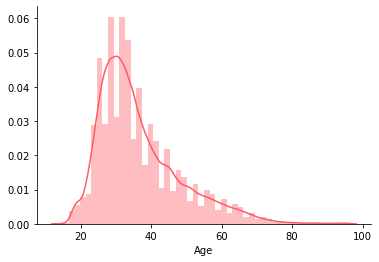

In [55]:
sns.distplot(UsersTrainingDataPD.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

As expected, the common age to travel is between 25 and 40. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups. Maybe 45?

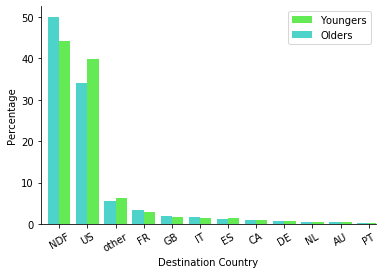

In [57]:
age = 45

younger = sum(UsersTrainingDataPD.loc[UsersTrainingDataPD['age'] < age, 'country_destination'].value_counts())
older = sum(UsersTrainingDataPD.loc[UsersTrainingDataPD['age'] > age, 'country_destination'].value_counts())

younger_destinations = UsersTrainingDataPD.loc[UsersTrainingDataPD['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = UsersTrainingDataPD.loc[UsersTrainingDataPD['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=0.4, color='#63EA55', position=0, label='Youngers', rot=30)
older_destinations.plot(kind='bar', width=0.4, color='#4DD3C9', position=1, label='Olders', rot=30)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

In [58]:
younger_destinations

NDF      44.137158
US       39.972848
other     6.180128
FR        2.878712
IT        1.585914
ES        1.427528
GB        1.314396
CA        0.855694
DE        0.678796
NL        0.493670
AU        0.345569
PT        0.129588
Name: country_destination, dtype: float64

In [59]:
older_destinations

NDF      50.059357
US       33.956584
other     5.469346
FR        3.319766
GB        1.806156
IT        1.763758
ES        1.132027
CA        0.894598
DE        0.686848
NL        0.432460
AU        0.360383
PT        0.118714
Name: country_destination, dtype: float64

We can see that there are no big differences between the young people and the older people. We need to consider that we do not have the 42% of the ages. 

As per the previous plots, `age` is not affecting the Destination Country selection, so we can drop it.

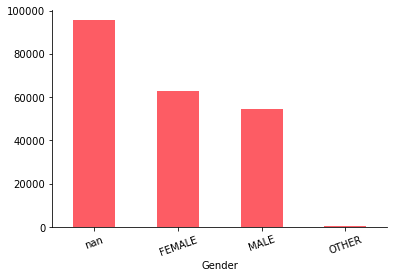

In [60]:
UsersTrainingDataPD.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=20)
plt.xlabel('Gender')
sns.despine()

In [61]:
UsersTrainingDataPD.gender

0            NaN
1           MALE
2         FEMALE
3         FEMALE
4            NaN
           ...  
213446      MALE
213447       NaN
213448       NaN
213449       NaN
213450       NaN
Name: gender, Length: 213451, dtype: object

As we've seen before at this plot we can see the amount of missing data in perspective. Also, notice that there is a slight difference between user gender.

Next thing it might be interesting to see if there is any gender preferences when travelling:

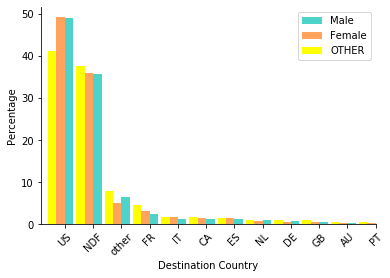

In [63]:
women = sum(UsersTrainingDataPD['gender'] == 'FEMALE')
men = sum(UsersTrainingDataPD['gender'] == 'MALE')
other = sum(UsersTrainingDataPD['gender'] == 'OTHER')

female_destinations = UsersTrainingDataPD.loc[UsersTrainingDataPD['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = UsersTrainingDataPD.loc[UsersTrainingDataPD['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100
other_destinations = UsersTrainingDataPD.loc[UsersTrainingDataPD['gender'] == 'OTHER', 'country_destination'].value_counts() / other * 100

# Bar width
width = 0.3

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=45)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=45)
other_destinations.plot(kind='bar', width=width, color='yellow', position=2, label='OTHER', rot=45)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

There are no big differences between the 2 main genders, so this plot it's not really usefull except to know the relative destination frecuency of the countries. Let's see it clear here:

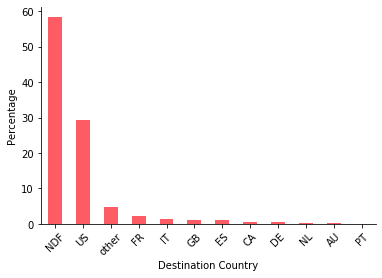

In [64]:
destination_percentage = UsersTrainingDataPD.country_destination.value_counts() / UsersTrainingDataPD.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=45)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

As per the previous plots, `Gender` is not affecting the Destination Country selection, so we can drop it.

Let's check the native language when choosing the destination country. So let's see how manny users use English as main language:

In [66]:
print((sum(UsersTrainingDataPD.language == 'en') / UsersTrainingDataPD.shape[0])*100)

96.65637546790599


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. Someone maybe thinking, if the language is important, why not travel to GB? We need to remember that there is also a lot of factor we are not acounting so making assumpions or predictions like that might be dangerous.

`date_first_booking`: As we are seeking to predict users first booking destination so (date_first_booking) does not exist in our test data, also 58% of its values are nulls, so we can drop it.

`timestamp_first_active` | `date_account_created`: after training experiments found that those dates as features affect the accuracy results negatively.

In [68]:
# drop records with null values
SessionsData_without_na = SessionsData.dropna()

In [69]:
SessionsData_without_na.columns

['user_id',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed']

In [70]:
# list the categorical columns in the sessions data
Sessions_cat_cols = [item[0] for item in SessionsData_without_na.dtypes if item[1].startswith('string')]

In [72]:
print('We have', len(Sessions_cat_cols), ' categorical columns in users sessions data')
Sessions_cat_cols

We have 5  categorical columns in users sessions data


['user_id', 'action', 'action_type', 'action_detail', 'device_type']

In [73]:
# list the numerical columns in the sessions data
Sessions_num_cols = [item[0] for item in SessionsData_without_na.dtypes if item[1].startswith('int') | item[1].startswith('double')] 

In [74]:
print('We have', len(Sessions_num_cols), ' numerical columns in users sessions data')
Sessions_num_cols

We have 1  numerical columns in users sessions data


['secs_elapsed']

In [75]:
# indexing the categorical columns as we cannot feed the training model with string data
Sessions_indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in Sessions_cat_cols if column not in ['user_id']]

In [76]:
Sessions_pipeline = Pipeline(stages=Sessions_indexers)

In [77]:
transformedSessionsDF = Sessions_pipeline.fit(SessionsData_without_na)\
                                        .transform(SessionsData_without_na)

In [78]:
transformedSessionsDF = transformedSessionsDF.drop('action', 'action_type', 'action_detail', 'device_type')

In [79]:
transformedSessionsDF.limit(5).toPandas()

,user_id,secs_elapsed,action_index,action_type_index,action_detail_index,device_type_index
0,d1mm9tcy42,67753.0,2.0,2.0,0.0,1.0
1,d1mm9tcy42,22141.0,2.0,2.0,0.0,1.0
2,d1mm9tcy42,7703.0,2.0,2.0,0.0,1.0
3,d1mm9tcy42,831.0,3.0,1.0,3.0,1.0
4,d1mm9tcy42,20842.0,1.0,0.0,0.0,1.0


In [80]:
# list sessions columns without user_id
columns = [column for column in transformedSessionsDF.columns if column != 'user_id']
columns

['secs_elapsed',
 'action_index',
 'action_type_index',
 'action_detail_index',
 'device_type_index']

In [81]:
# simplify sessions data using data statistics instead of actual data
# to be lightweight and able to be processed on one node cluster
funs = [pySFun.count, pySFun.sum, pySFun.max, pySFun.min, pySFun.stddev, pySFun.mean]

In [82]:
exprs = [f(pySFun.col(c)) for f in funs for c in columns]


In [83]:
exprs

[Column<b'count(secs_elapsed)'>,
 Column<b'count(action_index)'>,
 Column<b'count(action_type_index)'>,
 Column<b'count(action_detail_index)'>,
 Column<b'count(device_type_index)'>,
 Column<b'sum(secs_elapsed)'>,
 Column<b'sum(action_index)'>,
 Column<b'sum(action_type_index)'>,
 Column<b'sum(action_detail_index)'>,
 Column<b'sum(device_type_index)'>,
 Column<b'max(secs_elapsed)'>,
 Column<b'max(action_index)'>,
 Column<b'max(action_type_index)'>,
 Column<b'max(action_detail_index)'>,
 Column<b'max(device_type_index)'>,
 Column<b'min(secs_elapsed)'>,
 Column<b'min(action_index)'>,
 Column<b'min(action_type_index)'>,
 Column<b'min(action_detail_index)'>,
 Column<b'min(device_type_index)'>,
 Column<b'stddev_samp(secs_elapsed)'>,
 Column<b'stddev_samp(action_index)'>,
 Column<b'stddev_samp(action_type_index)'>,
 Column<b'stddev_samp(action_detail_index)'>,
 Column<b'stddev_samp(device_type_index)'>,
 Column<b'avg(secs_elapsed)'>,
 Column<b'avg(action_index)'>,
 Column<b'avg(action_type_in

In [84]:
transformedSessionsDF_summary = transformedSessionsDF.groupBy('user_id').agg(*exprs).dropna()

In [85]:
transformedSessionsDF_summary.count()

130375

In [86]:
transformedSessionsDF_summary.limit(5).toPandas()

,user_id,count(secs_elapsed),count(action_index),count(action_type_index),count(action_detail_index),count(device_type_index),sum(secs_elapsed),sum(action_index),sum(action_type_index),sum(action_detail_index),...,stddev_samp(secs_elapsed),stddev_samp(action_index),stddev_samp(action_type_index),stddev_samp(action_detail_index),stddev_samp(device_type_index),avg(secs_elapsed),avg(action_index),avg(action_type_index),avg(action_detail_index),avg(device_type_index)
0,9nut71te0s,53,53,53,53,53,1639273.0,468.0,70.0,397.0,...,87702.082327,10.925862,1.105469,8.413868,0.000000,30929.679245,8.830189,1.320755,7.490566,7.000000
1,zlv8f1qg2g,66,66,66,66,66,1155277.0,851.0,176.0,408.0,...,38619.808168,20.683051,0.966092,12.048503,0.000000,17504.196970,12.893939,2.666667,6.181818,0.000000
2,srykgkylee,2,2,2,2,2,246.0,186.0,6.0,4.0,...,111.722871,131.521861,0.000000,0.000000,0.000000,123.000000,93.000000,3.000000,2.000000,6.000000
3,funlgmcmr3,8,8,8,8,8,54421.0,64.0,9.0,53.0,...,12617.517776,8.783101,1.356203,5.755432,0.000000,6802.625000,8.000000,1.125000,6.625000,4.000000
4,mzduh7va3m,170,170,170,170,170,1483785.0,1651.0,505.0,410.0,...,62754.618005,32.218272,0.296458,3.198721,0.528215,8728.147059,9.711765,2.970588,2.411765,2.070588


In [87]:
# join users data and sessions data
# inner join used instead of left join to avoid nulls in training dataset
dataset = UsersTrainingData\
            .coalesce(1)\
            .join(transformedSessionsDF_summary, UsersTrainingData.id == transformedSessionsDF_summary.user_id)\
            .drop('id', 'user_id', 'age', 'date_account_created', 'timestamp_first_active', 'date_first_booking')

In [88]:
dataset.limit(10).toPandas()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,...,stddev_samp(secs_elapsed),stddev_samp(action_index),stddev_samp(action_type_index),stddev_samp(action_detail_index),stddev_samp(device_type_index),avg(secs_elapsed),avg(action_index),avg(action_type_index),avg(action_detail_index),avg(device_type_index)
0,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,...,65664.211460,41.900220,1.162660,22.365982,0.0,35326.913043,30.086957,1.521739,15.652174,0.0
1,-unknown-,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,...,25399.779135,19.134683,0.848201,4.044467,0.0,9024.716049,5.703704,0.740741,3.358025,0.0
2,MALE,facebook,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,...,348232.914625,22.365737,1.492042,18.337337,0.0,107051.285714,23.821429,0.821429,20.964286,1.0
3,MALE,facebook,0,en,remarketing,google,untracked,Web,Mac Desktop,Chrome,...,52836.263841,16.520190,1.258306,18.391574,0.0,26594.000000,13.250000,2.250000,12.750000,0.0
4,MALE,facebook,0,en,direct,direct,linked,Web,Mac Desktop,Safari,...,11736.721391,4.509250,1.732051,4.582576,0.0,7183.000000,7.333333,2.000000,8.000000,0.0
5,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,...,129991.043237,33.753451,1.422226,5.310795,0.0,43240.000000,44.750000,1.750000,6.750000,0.0
6,-unknown-,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,...,213371.033265,20.720137,1.228904,4.121076,0.0,50562.480000,9.680000,1.200000,4.420000,0.0
7,-unknown-,google,12,en,direct,direct,untracked,Android,Android Phone,-unknown-,...,4330.570863,3.464102,1.154701,8.082904,0.0,2719.000000,12.000000,2.333333,6.666667,3.0
8,FEMALE,facebook,0,en,content,google,omg,Web,Mac Desktop,Safari,...,148625.979826,5.935466,0.877344,4.712604,0.0,37028.535714,3.621429,1.207143,2.500000,0.0
9,-unknown-,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Safari,...,145080.772956,16.085053,0.986230,5.732775,0.0,38817.153846,10.065934,1.384615,5.186813,1.0


In [89]:
dataset.printSchema()

root
 |-- gender: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- count(secs_elapsed): long (nullable = false)
 |-- count(action_index): long (nullable = false)
 |-- count(action_type_index): long (nullable = false)
 |-- count(action_detail_index): long (nullable = false)
 |-- count(device_type_index): long (nullable = false)
 |-- sum(secs_elapsed): double (nullable = true)
 |-- sum(action_index): double (nullable = true)
 |-- sum(action_type_index): double (nullable = true)
 |-- sum(action_detail_index): double (nullable = true)
 |-- sum(dev

In [90]:
# split training dataset to 80% of data for training and 20% of data for testing
(UsersTrainSample, UsersTestSample) = dataset.randomSplit([0.8, 0.2])

In [91]:
# tried to avoid biased data in the dataset by taking unbiased data samples
# but after training experiments that did not enhance our results accuracy

#TrainData = dataset.sampleBy('country_destination', fractions= {
#        'NDF': 0.1,
#       'US': 0.1,
#        'other': 0.5,
#        'FR': 0.5,
#        'IT': 0.5,
#        'GB': 0.5,
#        'ES': 0.5,
#        'CA': 1,
#        'DE': 1,
#        'NL': 1,
#        'AU': 1,
#        'PT': 1
#    })

In [92]:
# list categorical columns
cat_cols = [item[0] for item in dataset.dtypes if item[1].startswith('string')] 

In [93]:
# list numerical columns
num_cols = [item[0] for item in dataset.dtypes if item[1].startswith('int') | item[1].startswith('double')] 

In [94]:
cat_cols

['gender',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [95]:
# indexing categorical columns
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in cat_cols]

In [96]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in cat_cols if column not in ['country_destination']]

In [97]:
# list required features
requiredFeatures = num_cols + [
                                'gender_encoded',
                                'signup_method_encoded',
                                'language_encoded',
                                'affiliate_channel_encoded',
                                'affiliate_provider_encoded',
                                'first_affiliate_tracked_encoded',
                                'signup_app_encoded',
                                'first_device_type_encoded',
                                'first_browser_encoded'
                                ]
requiredFeatures

['signup_flow',
 'sum(secs_elapsed)',
 'sum(action_index)',
 'sum(action_type_index)',
 'sum(action_detail_index)',
 'sum(device_type_index)',
 'max(secs_elapsed)',
 'max(action_index)',
 'max(action_type_index)',
 'max(action_detail_index)',
 'max(device_type_index)',
 'min(secs_elapsed)',
 'min(action_index)',
 'min(action_type_index)',
 'min(action_detail_index)',
 'min(device_type_index)',
 'stddev_samp(secs_elapsed)',
 'stddev_samp(action_index)',
 'stddev_samp(action_type_index)',
 'stddev_samp(action_detail_index)',
 'stddev_samp(device_type_index)',
 'avg(secs_elapsed)',
 'avg(action_index)',
 'avg(action_type_index)',
 'avg(action_detail_index)',
 'avg(device_type_index)',
 'gender_encoded',
 'signup_method_encoded',
 'language_encoded',
 'affiliate_channel_encoded',
 'affiliate_provider_encoded',
 'first_affiliate_tracked_encoded',
 'signup_app_encoded',
 'first_device_type_encoded',
 'first_browser_encoded']

In [98]:
# assemble data for training model
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [99]:
# use random forest algorithm for training
rf = RandomForestClassifier(labelCol='country_destination_index', 
                            featuresCol='features',
                            maxDepth=20)

In [100]:
pipeline = Pipeline(
    stages=indexers + encoders  + [assembler, rf]
)

In [60]:
model = pipeline.fit(UsersTrainSample)

In [61]:
predictions = model.transform(UsersTestSample)
# predictionsDF = predictions.toPandas()
# predictionsDF.head()

In [62]:
predictions = predictions.persist()

In [63]:
predictions_labels = predictions.select(
    'country_destination_index',
    'prediction'
)

predictions_labels.show()

+-------------------------+----------+
|country_destination_index|prediction|
+-------------------------+----------+
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      4.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      6.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
+-------------------------+----------+
only showing top 20 rows



In [64]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='country_destination_index', 
    predictionCol='prediction', 
    metricName='accuracy'
)

In [65]:
accuracy = evaluator.evaluate(predictions_labels)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.6660208109077862


In [66]:
predictions.toPandas().head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,...,affiliate_channel_encoded,affiliate_provider_encoded,first_affiliate_tracked_encoded,signup_app_encoded,first_device_type_encoded,first_browser_encoded,features,rawPrediction,probability,prediction
0,-unknown-,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 3352460.0, 457.0, 15.0, 441.0, 2.0, 1324...","[12.421119578659011, 5.116186500606994, 0.3638...","[0.6210559789329505, 0.25580932503034964, 0.01...",0.0
1,-unknown-,basic,0,en,direct,direct,product,Web,Windows Desktop,IE,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 776978.0, 49.0, 6.0, 42.0, 7.0, 420608.0...","[16.329895569955006, 2.3542501257709296, 0.275...","[0.8164947784977503, 0.11771250628854649, 0.01...",0.0
2,-unknown-,basic,0,en,direct,direct,tracked-other,Web,Mac Desktop,Safari,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 103939.0, 20.0, 3.0, 18.0, 0.0, 99035.0,...","[13.292719229411157, 2.339832026346223, 1.1641...","[0.6646359614705577, 0.11699160131731112, 0.05...",0.0
3,-unknown-,basic,0,en,direct,direct,untracked,Web,Desktop (Other),Chrome,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2952466.0, 978.0, 151.0, 606.0, 1000.0, ...","[13.656757415205428, 2.1145767656436485, 1.807...","[0.6828378707602715, 0.10572883828218245, 0.09...",0.0
4,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 21782.0, 66.0, 7.0, 54.0, 0.0, 17354.0, ...","[14.73893414067521, 4.2081319661521785, 0.2695...","[0.7369467070337603, 0.21040659830760886, 0.01...",0.0


In [67]:
# list countries distination indexes
country_destination_index = predictions.select('country_destination', 'country_destination_index')\
                                        .distinct()\
                                        .orderBy('country_destination_index')\
                                        .collect()

In [68]:
country_destination_indexes = {i[1]: i[0] for i in country_destination_index}

In [69]:
country_destination_indexes

{0.0: 'NDF',
 1.0: 'US',
 2.0: 'other',
 3.0: 'FR',
 4.0: 'IT',
 5.0: 'GB',
 6.0: 'ES',
 7.0: 'CA',
 8.0: 'NL',
 9.0: 'DE',
 10.0: 'AU',
 11.0: 'PT'}

#### apply NDCG (Normalized discounted cumulative gain) method of accuracy evaluation

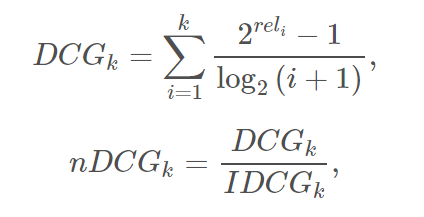

In [70]:
def reverse_sorted_predictions_func(probabilities):
    result = [
       country_destination_indexes[i] for i in \
            sorted(range(len(probabilities)),
                key=lambda k: float(probabilities[k]),
                reverse = True
            ) \
            if i < len(country_destination_indexes)
    ]
    # Return only first 5 countries
    return result[:5]

In [71]:
reverse_sorted_predictions_udf = pySFun.udf(lambda probabilities: reverse_sorted_predictions_func(probabilities), ArrayType(StringType()))

In [72]:
def NDCG_from_probabilities_func(lable, probabilities):
    prediction_array = sorted(
        range(len(probabilities)),
        key=lambda k: float(probabilities[k]),
        reverse = True
    )
    
    # Only heighest 5 predictions
    prediction_array = prediction_array[:5]
    
    for i, val in enumerate(prediction_array):
        if (val == lable):
            return float(1 / np.log2((i+1) + 1))
    return 0

In [73]:
NDCG_from_probabilities_udf = pySFun.udf(lambda lable, probabilities: NDCG_from_probabilities_func(lable, probabilities), DoubleType())

In [74]:
predictionsDF = predictions.withColumn('reverse_sorted_predictions', reverse_sorted_predictions_udf(predictions.probability))\
                        .withColumn('NDCG', NDCG_from_probabilities_udf(predictions.country_destination_index, predictions.probability))

In [75]:
predictionsDF.toPandas()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,...,first_affiliate_tracked_encoded,signup_app_encoded,first_device_type_encoded,first_browser_encoded,features,rawPrediction,probability,prediction,reverse_sorted_predictions,NDCG
0,-unknown-,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 3352460.0, 457.0, 15.0, 441.0, 2.0, 1324...","[12.421119578659011, 5.116186500606994, 0.3638...","[0.6210559789329505, 0.25580932503034964, 0.01...",0.0,"[NDF, US, FR, GB, other]",1.00000
1,-unknown-,basic,0,en,direct,direct,product,Web,Windows Desktop,IE,...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 776978.0, 49.0, 6.0, 42.0, 7.0, 420608.0...","[16.329895569955006, 2.3542501257709296, 0.275...","[0.8164947784977503, 0.11771250628854649, 0.01...",0.0,"[NDF, US, GB, other, CA]",1.00000
2,-unknown-,basic,0,en,direct,direct,tracked-other,Web,Mac Desktop,Safari,...,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 103939.0, 20.0, 3.0, 18.0, 0.0, 99035.0,...","[13.292719229411157, 2.339832026346223, 1.1641...","[0.6646359614705577, 0.11699160131731112, 0.05...",0.0,"[NDF, US, IT, other, CA]",1.00000
3,-unknown-,basic,0,en,direct,direct,untracked,Web,Desktop (Other),Chrome,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2952466.0, 978.0, 151.0, 606.0, 1000.0, ...","[13.656757415205428, 2.1145767656436485, 1.807...","[0.6828378707602715, 0.10572883828218245, 0.09...",0.0,"[NDF, US, IT, other, GB]",0.63093
4,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 21782.0, 66.0, 7.0, 54.0, 0.0, 17354.0, ...","[14.73893414067521, 4.2081319661521785, 0.2695...","[0.7369467070337603, 0.21040659830760886, 0.01...",0.0,"[NDF, US, other, FR, IT]",1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13930,MALE,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1520167.0, 425.0, 126.0, 402.0, 87.0, 24...","[11.129755721598437, 5.358196782089855, 0.8699...","[0.5564877860799221, 0.26790983910449284, 0.04...",0.0,"[NDF, US, FR, IT, other]",0.63093
13931,MALE,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 4498671.0, 2537.0, 321.0, 1649.0, 0.0, 1...","[5.133789065951429, 10.622769228583747, 0.6006...","[0.2566894532975715, 0.5311384614291874, 0.030...",1.0,"[US, NDF, IT, FR, other]",1.00000
13932,MALE,facebook,12,en,api,other,untracked,iOS,iPhone,-unknown-,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(12.0, 38019.0, 0.0, 6.0, 4.0, 12.0, 37589.0, ...","[14.481888273492547, 5.252007226399551, 0.0764...","[0.7240944136746272, 0.26260036131997755, 0.00...",0.0,"[NDF, US, ES, other, IT]",1.00000
13933,MALE,facebook,12,en,api,other,untracked,iOS,iPhone,Mobile Safari,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0

In [76]:
predictionsDF.select('NDCG').groupBy().avg().collect()[0][0]

0.8732835540986115

In [77]:
testingDataset = UsersTestingData\
            .coalesce(1)\
            .join(transformedSessionsDF_summary, UsersTestingData.id == transformedSessionsDF_summary.user_id)

In [78]:
testingDataset.columns

['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'user_id',
 'count(secs_elapsed)',
 'count(action_index)',
 'count(action_type_index)',
 'count(action_detail_index)',
 'count(device_type_index)',
 'sum(secs_elapsed)',
 'sum(action_index)',
 'sum(action_type_index)',
 'sum(action_detail_index)',
 'sum(device_type_index)',
 'max(secs_elapsed)',
 'max(action_index)',
 'max(action_type_index)',
 'max(action_detail_index)',
 'max(device_type_index)',
 'min(secs_elapsed)',
 'min(action_index)',
 'min(action_type_index)',
 'min(action_detail_index)',
 'min(device_type_index)',
 'stddev_samp(secs_elapsed)',
 'stddev_samp(action_index)',
 'stddev_samp(action_type_index)',
 'stddev_samp(action_detail_index)',
 'stddev_samp(device_type_index)',
 'avg(secs_elapsed)',
 'avg

In [79]:
testingDataset.count()

60790

In [80]:
idCol = testingDataset.select('id').toPandas()

In [81]:
idCol.count()

id    60790
dtype: int64

In [82]:
idCol.head()

,id
0,ab6t9i0zbh
1,nh4n5oqhg0
2,0vik5hv9lx
3,at8y572uuv
4,p4ols4q2mi


In [83]:
testingDatasetForPredictions = testingDataset\
    .drop('id', 'user_id', 'age', 'date_account_created', 'timestamp_first_active', 'date_first_booking')

In [84]:
testingPredictions = model.transform(testingDatasetForPredictions)

In [85]:
testingPredictionsDF = testingPredictions.withColumn('reverse_sorted_predictions', reverse_sorted_predictions_udf(testingPredictions.probability))

In [86]:
testingPredictionsPandasDf = testingPredictionsDF.toPandas()

In [87]:
testingPredictionsWithIds = pd.concat([idCol, testingPredictionsPandasDf], axis=1)

In [88]:
resultsDf = testingPredictionsWithIds[['id', 'reverse_sorted_predictions']]
resultsDf.head()

,id,reverse_sorted_predictions
0,ab6t9i0zbh,"[NDF, US, other, IT, GB]"
1,nh4n5oqhg0,"[NDF, US, other, IT, FR]"
2,0vik5hv9lx,"[NDF, US, FR, GB, IT]"
3,at8y572uuv,"[NDF, US, other, IT, FR]"
4,p4ols4q2mi,"[NDF, US, FR, other, AU]"


In [89]:
resultsDf

,id,reverse_sorted_predictions
0,ab6t9i0zbh,"[NDF, US, other, IT, GB]"
1,nh4n5oqhg0,"[NDF, US, other, IT, FR]"
2,0vik5hv9lx,"[NDF, US, FR, GB, IT]"
3,at8y572uuv,"[NDF, US, other, IT, FR]"
4,p4ols4q2mi,"[NDF, US, FR, other, AU]"
...,...,...
60785,qs4pwvzgdg,"[US, NDF, other, ES, IT]"
60786,tqg727clbz,"[US, NDF, FR, other, ES]"
60787,0b9o9pnjpw,"[NDF, US, ES, FR, other]"
60788,9cndlww9xa,"[NDF, US, other, ES, FR]"


In [90]:
from pyspark.sql.functions import explode

In [91]:
results = spark.createDataFrame(resultsDf)

In [92]:
results.printSchema()
results.show(5)

root
 |-- id: string (nullable = true)
 |-- reverse_sorted_predictions: array (nullable = true)
 |    |-- element: string (containsNull = true)

+----------+--------------------------+
|        id|reverse_sorted_predictions|
+----------+--------------------------+
|ab6t9i0zbh|      [NDF, US, other, ...|
|nh4n5oqhg0|      [NDF, US, other, ...|
|0vik5hv9lx|      [NDF, US, FR, GB,...|
|at8y572uuv|      [NDF, US, other, ...|
|p4ols4q2mi|      [NDF, US, FR, oth...|
+----------+--------------------------+
only showing top 5 rows



In [93]:
explodedResults = results.select(results.id,explode(results.reverse_sorted_predictions).alias('country'))

In [94]:
explodedResults.show(20)

+----------+-------+
|        id|country|
+----------+-------+
|ab6t9i0zbh|    NDF|
|ab6t9i0zbh|     US|
|ab6t9i0zbh|  other|
|ab6t9i0zbh|     IT|
|ab6t9i0zbh|     GB|
|nh4n5oqhg0|    NDF|
|nh4n5oqhg0|     US|
|nh4n5oqhg0|  other|
|nh4n5oqhg0|     IT|
|nh4n5oqhg0|     FR|
|0vik5hv9lx|    NDF|
|0vik5hv9lx|     US|
|0vik5hv9lx|     FR|
|0vik5hv9lx|     GB|
|0vik5hv9lx|     IT|
|at8y572uuv|    NDF|
|at8y572uuv|     US|
|at8y572uuv|  other|
|at8y572uuv|     IT|
|at8y572uuv|     FR|
+----------+-------+
only showing top 20 rows



In [95]:
explodedResults.coalesce(1).write.format('csv').save('./data/results.csv',header = 'true')

# Kaggle submission result

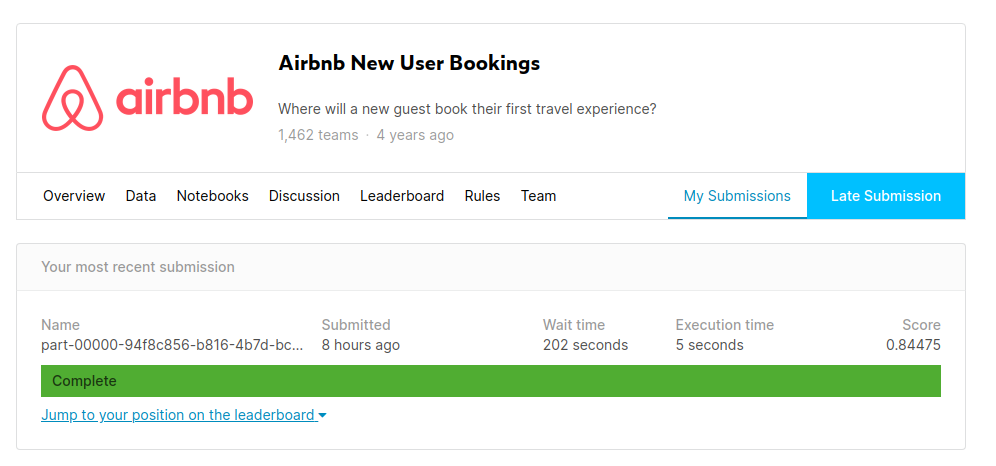

In [1]:
from IPython.display import Image
Image(filename="./Screenshot from 2020-05-10 01-43-13.png")